## Model Spring Model with Control

In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import simps

In [2]:
def transpose(x):
    '''a function used to take transpose of each matrix inside a tensor x
     x is a tensor n*d*c, return n*c*d'''
    d = len(x[0,:,0])                       #num of rows of each matrix
    c = len(x[0,0,:])                       #num of columns of each matrix
    n = len(x[:,0,0])                       #num of matrices in the tensor x
    
    X_T = np.zeros([n,c,d],dtype = complex)  #allocate space
    for i in range(d):
        X_T[:,:,i]=x[:,i,:]
    return X_T

### <li> Approach 1

#### Model and Cost Rate
<ui>
    <li> Model: $$X_{n+1}=AX_n+BU_n+Wn$$</li>
    <li> Cost rate: $$J_n(G) = \mathbb{E}[ |X_{n+1}|^2+r|U_{n}|^2 ]$$
        We are looking for the control in the form of $U_n=GX_n$, where $G=\begin{pmatrix}G_1 & G_2\end{pmatrix}$, $B=\begin{pmatrix}0 \\1 \end{pmatrix}$.
        Therefore, our aim is to find $G$ such that the cost rate is minimized in the steady state.</li>

#### Covariance matrix $S$ of $X$

<ui>
    <li> Let $S_n$ be the covariance matrix of $X_n$, $R$ be the covariance matrix of noise $W_n$, then
        $$S_{n+1}=(A+BG)S_n(A+BG)^T+R$$ </li>
    <li> In the steady state, if let $M=A+BG$, we will have 
        $$S=(A+BG)S(A+BG)^T+R=MSM^T+R$$ </li>
    <li> As $S$ is a symmetric matrix, we can rewrite the above equation as
        $$ \begin{pmatrix} S_{11} \\ S_{12} \\S_{22} \end{pmatrix}
        = \begin{pmatrix} M_{11}^2      & 2M_{11}M_{12}             & M_{12}^2 \\
                          M_{11}M_{21}  & M_{11}M_{22}+M_{12}M_{21} & M_{22}M_{12}\\ 
                          M_{21}^2      & 2M_{21}M_{22}             & M_{22}^2 
          \end{pmatrix} 
          \begin{pmatrix} S_{11} \\ S_{12} \\S_{22} \end{pmatrix}
        + \begin{pmatrix} R_{11}\\R_{12}\\R_{22} \end{pmatrix} $$ </li>
    <li> Let $\xi_S = \begin{pmatrix} S_{11} \\ S_{12} \\S_{22} \end{pmatrix}$, 
        $D = \begin{pmatrix} M_{11}^2      & 2M_{11}M_{12}             & M_{12}^2 \\
                          M_{11}M_{21}  & M_{11}M_{22}+M_{12}M_{21} & M_{22}M_{12}\\ 
                          M_{21}^2      & 2M_{21}M_{22}             & M_{22}^2 
          \end{pmatrix} $,
         $\xi_R=\begin{pmatrix} R_{11}\\R_{12}\\R_{22} \end{pmatrix} $, then
         $$\xi_S=D\xi_S+\xi_R, \space  (I-D)\xi_S=\xi_R$$  </li>


#### Differentiate $S$ w.r.t $G$
<ui>
    <li> If differentiating $S$ with repect to parameter $\theta$ in the steady state, according to chain rule we will get $$\dot{S} = M\dot{S}M^T + \dot{M}SM^T+MS\dot{M}^T$$ </li>
    <li> Let $u= \dot{M}SM^T+MS\dot{M}^T$, then by the similar method above, we will have 
$$(I-D)\xi_{\dot{S}}=\xi_u$$ </li>
    <li> Another way to get $\xi_{\dot{S}}$ is to differentiate $(I-D)\xi_S$:
        $$\begin{align*} 0 &=  -\dot{D}\xi_S+(I-D)\xi_\dot{S} \\  
        \xi_\dot{S} &= (I-D)^{-1}\dot{D}\xi_S \\
        &= (I-D)^{-1} \dot{D}(I-D)^{-1} \xi_R
        \end{align*}$$
Let's denote $E = (I-D)^{-1}$, then $$\xi_{\dot{S}} = E \dot{D}E\xi_R$$

#### Use $S$ to represent the cost rate

<ui> 
    <li> $\mathbb{E}[X^TX]=\text{tr}(S)$</li>
    <li> $\mathbb{E}[U^TrU]=\text{tr}(X^TG^TrGX) = \text{tr}(G^TrGXX^T) = \text{tr}(G^TrGS) =\text{tr}(rGSG^T)
    \space \text{(cyclic propery of trace) } $ </li>
    <li> Then the cost rate can be represented as 
        $$J_n(G) =\text{tr}(S) + \text{tr}(rGSG^T) $$ </li>
    <li> Differentiate $J_n$ w.r.t $\theta$ gives 
    $$\begin{align*} 0 &= \frac{\partial J}{\partial \theta} \\
    &= \text{tr}({\dot{S}})+\text{tr}(r(\dot{G}SG^T+G\dot{S}G^T+GS\dot{G}^T)) \\
    &= \text{tr}({\dot{S}})+\text{tr}(r(2GS\dot{G}^T + G\dot{S}G^T))\end{align*}$$
   where $\theta$ is $G_1$ or $G_2$</li>


Then, we want to use $G$ to represent $S$ and $\dot{S}$ in the above equation:
<li> $ \xi_S= E\xi_R$ </li>
<li> $ \xi_\dot{S} = E \dot{D}E \xi_R $ </li>
<li> $\text{tr}(\dot{S}) = \begin{pmatrix} 1 & 0 & 1 \end{pmatrix} \xi_{\dot{S}} := q\xi_{\dot{S}}$</li>

<li> $\text{tr}(r(2GS\dot{G}^T + G\dot{S}G^T)) = r(2GS\dot{G}^T + G\dot{S}G^T)$
    <li> $G\dot{S}G^T = \begin{pmatrix} G_1^2 & 2G_1G_2 & G_2^2 \end{pmatrix} \xi_{\dot{S}} := H\xi_{\dot{S}} $ </li>
    <li> Let $\xi_G = \begin{pmatrix} G_1 & G_2 & 0 \\ 0 & G_1 & G_2 \end{pmatrix},$  then 
    $ S\dot{G}^T = \xi_{\dot{G}}\xi_S $</li>
     
<li> Plugging them in the derivative of cost rate function: 
$$0 = q \xi_{\dot{S}} + r(H \xi_{\dot{S}}+ 2G \xi_{\dot{G}}\xi_S) $$
    
<li> Plugging in the formulas for $\xi_\dot{S}$ and $\xi_S$:
    $$0 =  [ qE\dot{D} + r(HE\dot{D}+ 2G \xi_{\dot{G}})]E\xi_R $$

The equation is only about $G_1$ and $G_2$, in the form of $f(G_1,G_2)=0$, so we can use Netwon's method to find out the value of $G_1$ and $G_2$.


#### Newton Method Iteration

Now we have two equations about $G_1$ and $G_2$:
$$0 = f_1(G_1,G_2), \space 0 = f_2(G_1,G_2)$$
Let denote $\begin{pmatrix} f_1 \\ f_2 \end{pmatrix} := F(G).$
We want to find solution $G$ such that $F(G)=0$

The Jacobian is 
$$J = \begin{pmatrix} \frac{\partial f_1}{\partial G_1}
                    & \frac{\partial f_1}{\partial G_2} \\ 
                      \frac{\partial f_2}{\partial G_1}
                    & \frac{\partial f_2}{\partial G_2}
      \end{pmatrix}$$

Then, the iteration is
$$G_{n+1} = G_n - J^{-1}F(G_n)$$

#### Appendix:
##### Some Helpful Calculations:
<li> Let $\frac{\partial{D}}{\partial G_1} = 
  \begin{pmatrix} 0             & 0              &   0     \\
                  a_{11}        & a_{12}         &   0     \\ 
                  2(a_{21}+G_1) & 2(a_{22}+G_2)  &   0 
  \end{pmatrix}$,
  $\frac{\partial{D}}{\partial G_2}  = 
  \begin{pmatrix} 0             & 0              &   0      \\
                  0             & a_{11}         &   a_{12} \\ 
                  0             & 2(a_{21}+G_1)  & 2(a_{22}+G_2) 
  \end{pmatrix}$,

<li> $D = \begin{pmatrix} M_{11}^2      & 2M_{11}M_{12}             & M_{12}^2 \\
                     M_{11}M_{21}  & M_{11}M_{22}+M_{12}M_{21} & M_{22}M_{12}\\ 
                     M_{21}^2      & 2M_{21}M_{22}             & M_{22}^2 
     \end{pmatrix} $
     
     

<li> $M_{11}=a_{11}\\M_{12}=a_{12}\\M_{21}=a_{21}+G_1\\M_{22}=a_{22}+G_2$
    
<li> $\xi_{G_1} = \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \end{pmatrix},$
     $\xi_{G_2} = \begin{pmatrix} 0 & 1 & 0 \\ 0 & 0 & 1 \end{pmatrix},$

In [3]:
def Jacobian(D_1,D_2,G1,G2,xi_G1,xi_G2,xi_R):
    '''Numerical Compute the Jacobian'''
    h        = 1e-5                             # a step size used in finite different methods
    f1_f1    = f(D,D_1,r,G1+h,G2,xi_G1,xi_R)    # f1 forward w.r.t G1
    f1_b1    = f(D,D_1,r,G1-h,G2,xi_G1,xi_R)    # f1 backward w.r.t G1
    f1_f2    = f(D,D_1,r,G1,G2+h,xi_G1,xi_R)    # f1 forward w.r.t G2
    f1_b2    = f(D,D_1,r,G1,G2-h,xi_G1,xi_R)    # f1 backward w.r.t G2
    
    f2_f1    = f(D,D_2,r,G1+h,G2,xi_G2,xi_R)    # f2 forward w.r.t G1
    f2_b1    = f(D,D_2,r,G1-h,G2,xi_G2,xi_R)    # f2 forward w.r.t G1
    f2_f2    = f(D,D_2,r,G1,G2+h,xi_G2,xi_R)    # f2 forward w.r.t G2
    f2_b2    = f(D,D_2,r,G1,G2-h,xi_G2,xi_R)    # f2 forward w.r.t G2
    
    J11      = (f1_f1-f1_b1)/(2*h)
    J12      = (f1_f2-f1_b2)/(2*h)
    J21      = (f2_f1-f2_b2)/(2*h)
    J22      = (f2_f2-f2_b2)/(2*h)
    J        = np.array([[J11,J12],[J21,J22]])
    return J

def f(D,D_dot,r,G1,G2,xi_Gdot,xi_R):
    '''the function we want to find the result f1(G1,G2)=0 or f2(G1,G2)=0
    @return: the value of G at this point'''
    q        = np.array([[1,0,1]])
    H        = np.array([[G1**2,2*G1*G2,G2**2]])
    E        = la.inv(np.eye(3)-D)
    G        = np.array([[G1,G2]])
    f_val    = (q@E@D_dot + r*(H@E@D_dot+2*G@xi_Gdot))@E@xi_R
    return f_val[0,0]


def F(D,D_1,D_2,r,G1,G2,xi_G1,xi_G2,xi_R):
    '''the function F = (f1,f2).T
    call f function twice and return a 2*1 matrix'''
    f1       = f(D,D_1,r,G1,G2,xi_G1,xi_R)
    f2       = f(D,D_2,r,G1,G2,xi_G2,xi_R)
    return np.array([[f1],[f2]])

def D_matrix(a11,a12,a21,a22,G1,G2):
    '''matrix D'''
    M11        = a11
    M12        = a12
    M21        = a21+G1
    M22        = a22+G2

    D   = np.array([[M11**2,  2*M11*M12,        M12**2 ],
                    [M11*M21, M11*M22+M12*M21,  M22*M12],
                    [M21**2,  2*M21*M22,        M22**2 ]])
    #print(M11,M12,M21,M22)
    return D

def D_partial_G1(a11,a12,a21,a22,G1,G2):
    '''The derivative of D w.r.t G1'''
    D_1 = np.array([[0,          0,                  0],
                    [a11,        a12,                0],
                    [2*(a21+G1), 2*(a22+G2),         0]])
    return D_1

def D_partial_G2(a11,a12,a21,a22,G1,G2):
    '''The derivative of D w.r.t G2'''
    D_2 = np.array([[0,          0,                  0],
                    [0,          a11,              a12],
                    [0,          2*(a21+G1), 2*(a22+G2)]])
    return D_2

In [4]:
## allocate space
D          = np.zeros([3,3])
R          = np.zeros([2,2])

h          = 1e-2                               #time step size used to decide the covariance matrix of Wn
sigma      = 0.1

## initial guess for G1 and G2
G1         = -0.1
G2         = -0.1
G          = np.array([[G1],[G2]])

## The derivative of xi_G
xi_G1    = np.array([[1,0,0],[0,1,0]])
xi_G2    = np.array([[0,1,0],[0,0,1]])


## constant parameters in alpha
k          = 0.1
m          = 1
gamma      = 0.05
alpha      = np.zeros([2,2])
alpha[0,1] = 1
alpha[1,0] = -k/m
alpha[1,1] = -gamma/m
    
## find xi_R (mathematical proof in Mass_Spring_Model_v3)
w, U       = la.eig(alpha)                        #spectral decomposition: dot(a[:,:], U[:,i]) = w[i] * U[:,i] 
                                                  #w are eigenvalues, the columns of U are eigenvectors
Diag       = np.diag(np.exp(w*h))                  #take the exponential of eigenvalue*dt and put them on the diagonal
A          = np.real(U@Diag@la.inv(U)) 
a11        = A[0,0]
a12        = A[0,1]
a21        = A[1,0]
a22        = A[1,1]
w1         = w[0]                                 #eigenvalues
w2         = w[1]
e1         = np.exp(2*w1*h) - 1                   #temp1
e2         = np.exp(2*w2*h) - 1                   #temp2
e3         = np.exp((w1+w2)*h) - 1
R[0,0]     = np.real(e1/(2*w1)+e2/(2*w2)-2*e3/(w1+w2))     #assign values
R[1,0]     = np.real(e1/2+e2/2-e3)
R[0,1]     = R[1,0]
R[1,1]     = np.real(w1*e1/2+w2*e2/2-2*w1*w2*e3/(w1+w2))
R          = np.real(R*(sigma/(w2-w1))**2)
xi_R       = np.zeros([3,1])
xi_R[0,0]  = R[0,0]
xi_R[1,0]  = R[1,0]
xi_R[2,0]  = R[1,1]

## parameter in cost function
r          = 0.1  

G1_list    = []
G2_list    = []
f1_list    = []
f2_list    = []

f1         = 1
f2         = 1
iteration  = 0

while np.maximum(abs(f1),abs(f2))>4e-14:
    ## initialize D and the derivative
    D          = D_matrix(a11,a12,a21,a22,G1,G2)
    D_1        = D_partial_G1(a11,a12,a21,a22,G1,G2)
    D_2        = D_partial_G2(a11,a12,a21,a22,G1,G2)
    J          = Jacobian(D_1,D_2,G1,G2,xi_G1,xi_G2,xi_R)
   
    F_val      = F(D,D_1,D_2,r,G1,G2,xi_G1,xi_G2,xi_R)
    G          = G - la.inv(J)@F_val
    G1         = G[0,0]
    G2         = G[1,0]
    G1_list.append(G1)
    G2_list.append(G2)
    f1         = F_val[0,0]
    f1_list.append(f1)
    f2         = F_val[1,0]
    f2_list.append(f2)
    xi_S       = la.inv(np.eye(3)-D)@xi_R
    iteration  += 1
    
    '''display some results to let you not feel bored'''
    if iteration%10000 == 0:
        print("iteration:",iteration)
        print("G1:",G1)
        print("G2:",G2)
        print("f1:",f1)
        print("f2:",f2)
        print("******************************")
        print()
        
    #print(G)

iteration: 10000
G1: 6119.033457744426
G2: 210.92833558938085
f1: 2.4869387905536746e-12
f2: -1.4740378249908408e-09
******************************

iteration: 20000
G1: 5159.703171013424
G2: 175.12388744273156
f1: 3.6026650437361227e-12
f2: -2.157181620126216e-09
******************************

iteration: 30000
G1: 3971.3949832061135
G2: 130.7525797620572
f1: 6.4478505963479824e-12
f2: -3.939117731538492e-09
******************************

iteration: 40000
G1: 2205.029602091977
G2: 64.65171322671537
f1: 2.634834819831524e-11
f2: -1.738401210645503e-08
******************************

iteration: 50000
G1: -23434.36576607083
G2: -9719082.922346128
f1: 2.0229787608087935e-09
f2: -4.87826386171591e-12
******************************

iteration: 60000
G1: -21861.388638934044
G2: -25372059.416172314
f1: 3.5423397266552863e-09
f2: -3.0522397519810036e-12
******************************

iteration: 70000
G1: -20239.244773439037
G2: -32350548.575770624
f1: 4.065263489540212e-09
f2: -2.54390817353

KeyboardInterrupt: 

In [56]:
print("The optimal parameter using newton method is \nG1 = "+str(G1)+"\nG2 = " + str(G2))



The optimal parameter using newton method is 
G1 = -30032.075500284685
G2 = -18992.785401980254


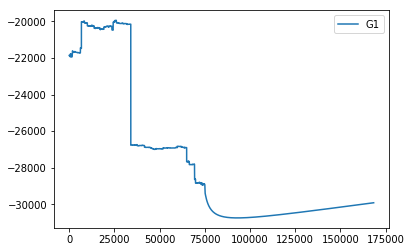

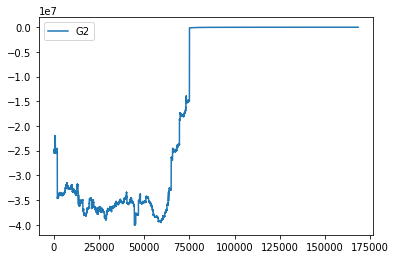

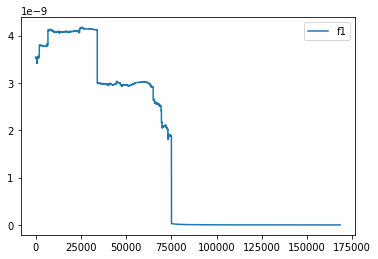

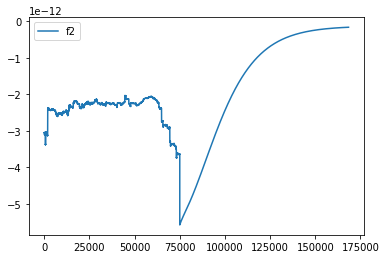

In [7]:
idx = 60000
plt.plot(G1_list[idx:],label="G1")
plt.legend()
plt.show()
plt.plot(G2_list[idx:],label="G2")
plt.legend()
plt.show()
plt.plot(f1_list[idx:],label="f1")
plt.legend()
plt.show()
plt.plot(f2_list[idx:],label="f2")
plt.legend()
plt.show()


<li> I found that Newton Method here is not efficient at all. And the parameter given is too large. If you apply such parameter to the model (which I have tried, it will show NaN) 

<li> Maybe there are some bug in code. But the main reason I believe is that we should not use Newton Method here. The function is very complicated and it may be a very ill-conditioned problem.

### <li> Approach 2

#### Differentiate Cost Rate $J_n$ w.r.t Control $U_n$
Consider the general case
$$\begin{align*} J_n &= \mathbb{E} [ U_n^TrU_n + X_{n+1}^TX_{n+1} ] \\
&= \mathbb{E} [ U_n^TrU_n + (AX_n+BU_n+W_n)^T(AX_n+BU_n+W_n)] \\
&= \mathbb{E} [ U_n^TrU_n + X_n^TA^TAX_n+X_n^TA^TBU_n+U_n^TB^TAX_n+U_n^TB^TBU_n ] + R
\end{align*}$$

We want to find $U_n$ which is the optimal control for minimizing $J_n$. Since $J_n$ is quadratic, we can find $U_n$ by letting $\frac{\partial}{\partial U_n} J_n = 0$. Thus,
$$0 = \frac{\partial}{\partial U_n} J_n = \mathbb{E} [2U_n^Tr^T+2X_n^TA^TB+2U_n^TB^TB ]$$ 
Therefore,
$$U_n=-(r+B^TB)^{-1}B^TAX_n$$

In [57]:
def mass_spring_process_LQR(x0,v0,n,N,k,m,gamma,sigma,h,r):
    '''simulate n independent paths, each with step N. 
    The state evolution satisfies Xn+1 = AXn + Wn'''
    
    ##allocate space
    X     = np.zeros([n,2,1])                    #each matrix is 2*1, has n matrices in X
    A     = np.zeros([n,2,2])                    #fundamental solution n*2*2
    B     = np.zeros([n,2,1])                    #control coefficient matrix
    alpha = np.zeros([2,2])                      #the alpha matrix in SDE(see in description above)
    R     = np.zeros([2,2],  dtype = complex)    #covariance matrix for W
    X_mat = np.zeros([n,N,2])                    #a matrix to record all the trajectory of X=[xn,vn]
    
    ##initialize X
    X[:,0,0] = x0                                #each matrix is [x0;
    X[:,1,0] = v0                                #                v0] 
    
    ##initialize B
    B[:,1,0] = 1                                 #only v direction is controlled
    B_T      = np.real(transpose(B))
    
    ##initialize alpha
    alpha[0,1] = 1
    alpha[1,0] = -k/m
    alpha[1,1] = -gamma/m
    
    ##initialize A = exp(alpha*dt)
    w, V = la.eig(alpha)                      #spectral decomposition: dot(a[:,:], V[:,i]) = w[i] * V[:,i] 
                                              #w are eigenvalues, the columns of V are eigenvectors
    D = np.diag(np.exp(w*h))                  #take the exponential of eigenvalue*dt and put them on the diagonal
    A_= V@D@la.inv(V)                         #the fundamental solution A(dt)
    A_=np.real(A_)
    A[:,0,0] = A_[0,0]                        #convert A_ from a 2*2 matrix to n*2*2 tensor, 
    A[:,0,1] = A_[0,1]                        #each matrix in tensor is the same
    A[:,1,0] = A_[1,0]
    A[:,1,1] = A_[1,1]
    
    ##initialize covariance matrix R of W
    w1 = w[0]                                 #eigenvalue
    w2 = w[1]
    e1 = np.exp(2*w1*h) - 1                   #temp1
    e2 = np.exp(2*w2*h) - 1                   #temp2
    e3 = np.exp((w1+w2)*h) - 1
    R[0,0] = e1/(2*w1)+e2/(2*w2)-2*e3/(w1+w2) #assign values
    R[1,0] = e1/2+e2/2-e3    
    R[0,1] = R[1,0]
    R[1,1] = w1*e1/2+w2*e2/2-2*w1*w2*e3/(w1+w2)
    R = R*(sigma/(w2-w1))**2
    
    ## initialize control matrix G=(G1 G2)
    G = -la.inv(r+B_T@B)@B_T@A
    #G = np.array([[-58368,-36632]])
    #G = np.array([[-.03,-.05]])
    for i in range(N): #time evolution
        ##generate noise W
        W = np.random.multivariate_normal(np.array([0,0]),np.real(R),n) #mean is [0,0] for Wn
        W = np.reshape(W,[n,2,1])                                       #reshape W to make it n*2*1
        U = G@X
        #print(U)
        ##time evolution with noise
        X = A@X+W+B@U
        X_mat[:,i,0] = X[:,0,0].T
        X_mat[:,i,1] = X[:,1,0].T
    #print(np.size(X_mat))
    return G[0,:,:],A,R,np.real(X_mat) #the imaginary part of X are almost zero (in theory should be zero)

In [58]:
##initialization
x0    = 2                     #initial position
v0    = 0                     #initial velocity

n     = int(5e+2)             #num of paths
t1    = 280                     #end time
h     = 0.01                  #time interval delta t
N     = int(t1/h+1)           #the num of steps of each path
t     = np.linspace(0, t1, N) #time steps (0, t1, t1/h+1)

k     = 2                     #spring constant
m     = 1                     #mass
gamma = 0.1                   #fraction coefficient
sigma = 0.1                   #noise coefficent in SDE

r     = 0.1*np.ones([1,1])    #coefficient in cost rate function

##simulate the process
G,A,R,X_mat = mass_spring_process_LQR(x0,v0,n,N,k,m,gamma,sigma,h,r)
#A fundamental solution   n*2*2
#R covariance matrix of W 2*2
#X_mat trajectory of n paths [xn,vn] (n*N*2)

X     = np.reshape(X_mat[:,-1,:],[n,2,1])         #Xn of n paths at t1, each of the form [xn;vn]
X_T   = transpose(X)
U     = G@X


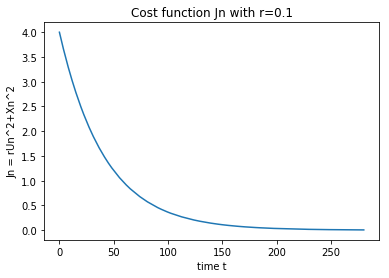

In [59]:
plt.plot(t,np.average(r*U[1:,:,0]**2+X_mat[:-1,:,0]**2,axis=0))
plt.title("Cost function Jn with r="+str(r[0,0]))
plt.xlabel("time t")
plt.ylabel("Jn = rUn^2+Xn^2")
plt.show()

In [62]:
G1 = G[0,0]
G2 = G[0,1]
print("The optimal parameter using newton method is \nG1 = "+str(G1)+"\nG2 = " + str(G2))


The optimal parameter using newton method is 
G1 = 0.01817212455066378
G2 = -0.9080914255824583


In [63]:
## plug in G1 G2 into our equation
D          = D_matrix(a11,a12,a21,a22,G1,G2)
D_1        = D_partial_G1(a11,a12,a21,a22,G1,G2)
D_2        = D_partial_G2(a11,a12,a21,a22,G1,G2)
F_val      = F(D,D_1,D_2,r,G1,G2,xi_G1,xi_G2,xi_R)
print("F(G1,G2):\n",F_val)

F(G1,G2):
 [[ 4.29576934e-03]
 [-2.22950296e-05]]


##### Remark:
If the formula in approach 1 is right, then F(G1,G2) should be zero. This shows that the there is something wrong with the formula.